## IMPORTANTO BIBLIOTECAS

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! echo '{"username":"costadv","key":"ed3c00112668adca4758c5cfd440287a"}' > kaggle.json
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
!unzip /content/ct-kidney-dataset-normal-cyst-tumor-and-stone.zip
!mkdir '/content/'
!mkdir '/content/trabalho/'
!mkdir '/content/trabalho/cyst'
!mkdir '/content/trabalho/stone'
!mkdir '/content/trabalho/tumor'
!mkdir '/content/trabalho/normal'
!cp -v '//content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/'* '/content/trabalho/normal/'
!cp -v '//content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/'* '/content/trabalho/cyst/'
!cp -v '//content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/'* '/content/trabalho/stone/'
!cp -v '//content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/'* '/content/trabalho/tumor/'

Streaming output truncated to the last 5000 lines.
'//content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3133).jpg' -> '/content/trabalho/cyst/Cyst- (3133).jpg'
'//content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3134).jpg' -> '/content/trabalho/cyst/Cyst- (3134).jpg'
'//content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3135).jpg' -> '/content/trabalho/cyst/Cyst- (3135).jpg'
'//content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3136).jpg' -> '/content/trabalho/cyst/Cyst- (3136).jpg'
'//content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3137).jpg' -> '/content/trabalho/cyst/Cyst- (3137).jpg'
'//content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (3138).jpg' -> '/content/tra

In [ ]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing import image
from tensorflow import keras

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import os

## PARÂMETROS

In [ ]:
percentege_test_size = 0.1
undersampling_size = 860 # -1 para não fazer undersampling // 1300 se não for filtrar as imagens

# fig preprocessing
largura = 128
altura = 128
modo_de_cor = 'grayscale' # rgb, grayscale, rgba
diretorio = '/content/trabalho/'

### CARREGANDO DATASET

In [ ]:
targets = [x[0].replace(diretorio,'') for x in os.walk(diretorio)]
targets = targets[1:len(targets)]
dados = []
class_to_int = {}
int_to_class = {}

k = 0

for classe in targets:
    imagens = os.listdir(diretorio+classe)
    i = 0
    class_to_int[classe] = k
    int_to_class[k] = classe
    k+=1
    for img in imagens:
        
        if (not '.txt' in img) and (not 'segmentation' in img) and (not 'desktop.ini' in img):
            aux = image.img_to_array(image.load_img(diretorio+classe+'/'+img)).shape
            if aux[0] == aux[1]:
              dados.append([diretorio+classe+'/'+img,class_to_int[classe]])
              i+=1
        
        if(i == undersampling_size and undersampling_size != -1):
            break

dados = np.array(dados)
np.random.shuffle(dados)
df_dados = pd.DataFrame(dados,columns=['image','target'])
df_dados['target'] = df_dados['target'].astype('int64', copy=False)
df_dados

,image,target
0,/content/trabalho/tumor/Tumor- (479).jpg,1
1,/content/trabalho/normal/Normal- (3802).jpg,2
2,/content/trabalho/tumor/Tumor- (1167).jpg,1
3,/content/trabalho/normal/Normal- (2858).jpg,2
4,/content/trabalho/normal/Normal- (4944).jpg,2
...,...,...
3435,/content/trabalho/normal/Normal- (3626).jpg,2
3436,/content/trabalho/stone/Stone- (1324).jpg,0
3437,/content/trabalho/tumor/Tumor- (1445).jpg,1
3438,/content/trabalho/normal/Normal- (2823).jpg,2


In [ ]:
df_dados['target'].value_counts()

1    860
2    860
3    860
0    860
Name: target, dtype: int64

## PREPARANDO DADOS

In [ ]:
def embedding(img_path,largura,altura,modo_de_cor):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)

    return embed

In [ ]:
y_full = df_dados['target'].array.to_numpy()
X_full  = []
for x in dados:
  X_full.append(embedding(x[0],largura,altura,modo_de_cor))
X_full = np.array(X_full)


In [ ]:
model_test_size = int(len(y_full) * percentege_test_size)

X_test, X_train = X_full[:model_test_size] / 255.0, X_full[model_test_size:] / 255.0
y_test, y_train = y_full[:model_test_size], y_full[model_test_size:]
df_dados_test = df_dados[:model_test_size]

## TREINANDO E VALIDANDO O MODELO

In [ ]:
shape_entrada = (largura,altura,1)

if(modo_de_cor == 'rgb'):
    shape_entrada = (largura,altura,3)

if(modo_de_cor == 'rgba'):
    shape_entrada = (largura,altura,4)

modelAdam = keras.models.Sequential([
                                     keras.layers.InputLayer(input_shape=shape_entrada),
                                     keras.layers.Conv2D(32, (5, 5), activation='relu', strides=(1, 1), padding='same'),
                                     keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
                                     keras.layers.Conv2D(64, (5, 5), activation='relu', strides=(2, 2), padding='same'),
                                     keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
                                     keras.layers.Conv2D(128, (3, 3), activation='relu', strides=(2, 2), padding='same'),
                                     keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
                                     keras.layers.Flatten(),
                                     keras.layers.Dense(64, activation="relu"),
                                     keras.layers.Dense(128, activation="relu"),
                                     keras.layers.Dense(32, activation="relu"),
                                     keras.layers.Dense(len(np.unique(y_train)), activation="softmax")
])

modelSGD = keras.models.Sequential([
                                    keras.layers.InputLayer(input_shape=shape_entrada),
                                    keras.layers.Conv2D(32, (5, 5), activation='tanh', strides=(1, 1), padding='same'),
                                    keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
                                    keras.layers.Conv2D(64, (5, 5), activation='tanh', strides=(2, 2), padding='same'),
                                    keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
                                    keras.layers.Conv2D(128, (3, 3), activation='tanh', strides=(2, 2), padding='same'),
                                    keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
                                    keras.layers.Flatten(),
                                    keras.layers.Dense(64, activation="tanh"),
                                    keras.layers.Dense(128, activation="tanh"),
                                    keras.layers.Dense(32, activation="tanh"),
                                    keras.layers.Dense(len(np.unique(y_train)), activation="exponential")
])

modelAdamax = keras.models.Sequential([
                                     keras.layers.InputLayer(input_shape=shape_entrada),
                                     keras.layers.Conv2D(32, (5, 5), activation='tanh', strides=(1, 1), padding='same'),
                                     keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
                                     keras.layers.Conv2D(64, (5, 5), activation='elu', strides=(2, 2), padding='same'),
                                     keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
                                     keras.layers.Conv2D(128, (3, 3), activation='relu', strides=(2, 2), padding='same'),
                                     keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
                                     keras.layers.Flatten(),
                                     keras.layers.Dense(64, activation="tanh"),
                                     keras.layers.Dense(128, activation="elu"),
                                     keras.layers.Dense(32, activation="relu"),
                                     keras.layers.Dense(len(np.unique(y_train)), activation="softmax")
])

modelMLP = keras.models.Sequential([
                                    keras.layers.Flatten(input_shape=shape_entrada),
                                    keras.layers.Dense(512, activation="tanh"),
                                    keras.layers.Dense(256, activation="tanh"),
                                    keras.layers.Dense(128, activation="tanh"),
                                    keras.layers.Dense(64, activation="tanh"),
                                    keras.layers.Dense(64, activation="elu"),
                                    keras.layers.Dense(64, activation="relu"),
                                    keras.layers.Dense(len(np.unique(y_train)), activation="softmax")
])

In [ ]:
print('model Adam')
modelAdam.summary()
print('model SGD')
modelSGD.summary()
print('model Adamax')
modelAdamax.summary()
print('model MLP')
modelMLP.summary()

model Adam
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 128, 128, 32)      832       
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 32, 32, 64)        51264     
                                                                 
 max_pooling2d_91 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_92 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_92 (MaxPoolin  (None, 4, 4,

In [ ]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')]

callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, verbose=0, restore_best_weights=True))

print(f'adam optimizer model')
modelAdam.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
historyAdam = modelAdam.fit(X_train, y_train, epochs=500, validation_split=0.05, callbacks=callbacks)
print(f'model adam training done.')

print(f'SGD optimizer model')
modelSGD.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
historySGD = modelSGD.fit(X_train, y_train, epochs=500, validation_split=0.05, callbacks=callbacks)
print(f'model SGD training done.')

print(f'adamax optimizer model')
modelAdamax.compile(loss="sparse_categorical_crossentropy", optimizer="adamax", metrics=["accuracy"])
historyAdamax = modelAdamax.fit(X_train, y_train, epochs=500, validation_split=0.05, callbacks=callbacks)
print(f'model adamax training done.')

print(f'MLP SGD optimizer model')
modelMLP.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
historyMLP = modelMLP.fit(X_train, y_train, epochs=500, validation_split=0.05, callbacks=callbacks)
print(f'model MLP training done.')

adam optimizer model
Epoch 1/500
92/92 [==============================] - 2s 18ms/step - loss: 0.7544 - accuracy: 0.6868 - val_loss: 0.3754 - val_accuracy: 0.8839 - lr: 0.0010
Epoch 2/500
92/92 [==============================] - 1s 16ms/step - loss: 0.0792 - accuracy: 0.9813 - val_loss: 0.0288 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/500
92/92 [==============================] - 1s 16ms/step - loss: 0.0126 - accuracy: 0.9980 - val_loss: 0.0035 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/500
92/92 [==============================] - 1s 16ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/500
92/92 [==============================] - 1s 16ms/step - loss: 9.4468e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/500
92/92 [==============================] - 1s 16ms/step - loss: 6.5633e-04 - accuracy: 1.0000 - val_loss: 8.6694e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/500
92/92 [==================

## VALIDANDO DE FORMA MAIS ELABORADA

model Adam


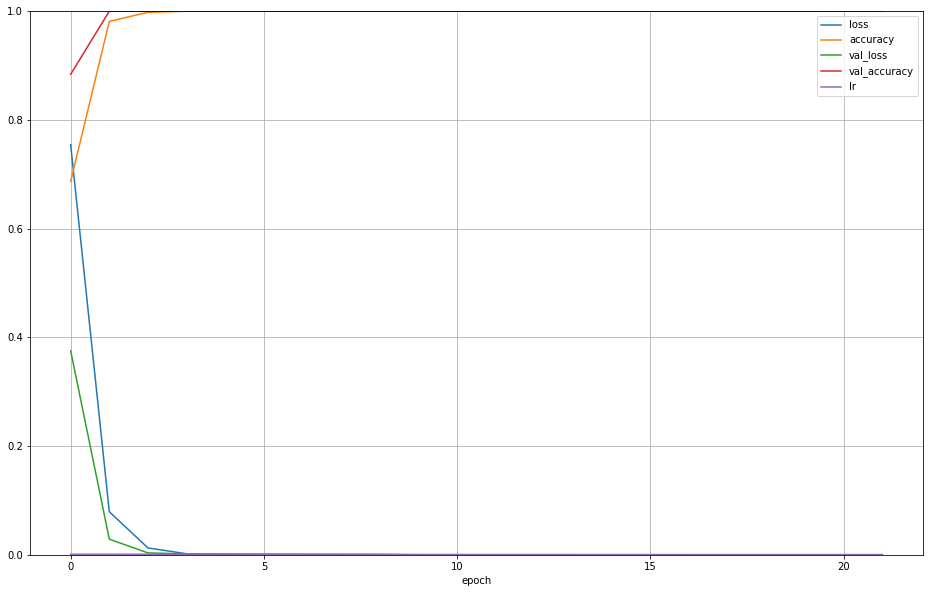

model SGD


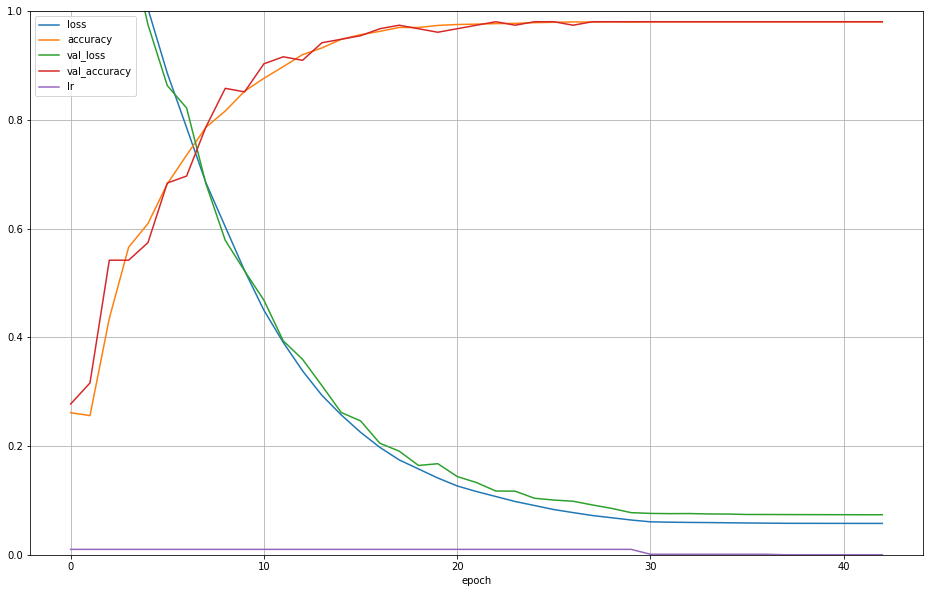

model adamax


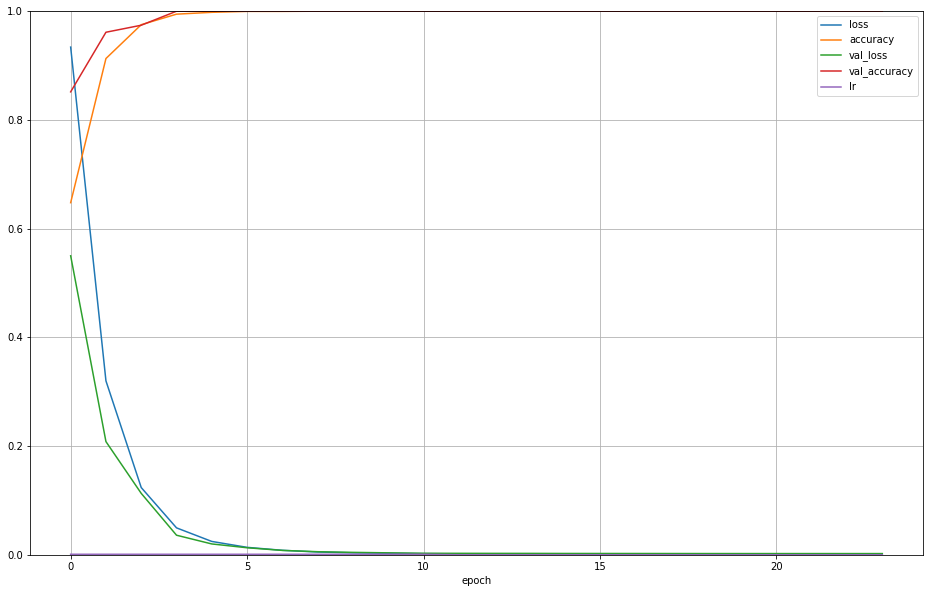

model MLP


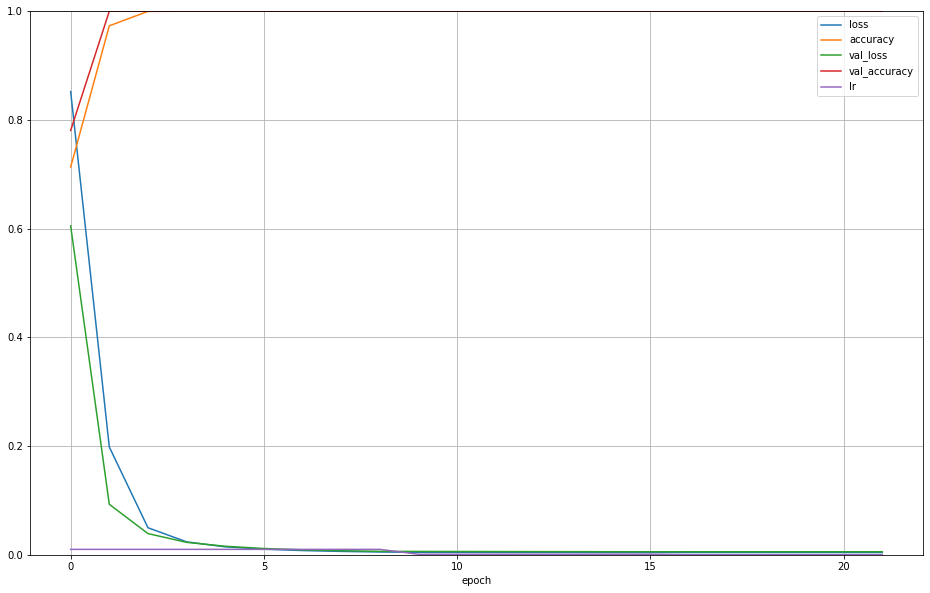

In [ ]:
print('model Adam')
pd.DataFrame(historyAdam.history).plot(figsize=(16, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('epoch')
plt.show()

print('model SGD')
pd.DataFrame(historySGD.history).plot(figsize=(16, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('epoch')
plt.show()

print('model adamax')
pd.DataFrame(historyAdamax.history).plot(figsize=(16, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('epoch')
plt.show()

print('model MLP')
pd.DataFrame(historyMLP.history).plot(figsize=(16, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('epoch')
plt.show()

In [ ]:
print('model Adam')
modelAdam.evaluate(X_test, y_test)
print('model SGD')
modelSGD.evaluate(X_test, y_test)
print('model Adamax')
modelAdamax.evaluate(X_test, y_test)
print('model MLP')
modelMLP.evaluate(X_test, y_test)

model Adam
11/11 [==============================] - 0s 10ms/step - loss: 0.0260 - accuracy: 0.9942
model SGD
11/11 [==============================] - 0s 10ms/step - loss: 0.1179 - accuracy: 0.9709
model Adamax
11/11 [==============================] - 0s 10ms/step - loss: 0.0361 - accuracy: 0.9971
model MLP
11/11 [==============================] - 0s 4ms/step - loss: 0.0884 - accuracy: 0.9971


[0.08838097006082535, 0.9970930218696594]

## VISUALIZANDO A MATRIZ DE CONFUSÃO

model Adam


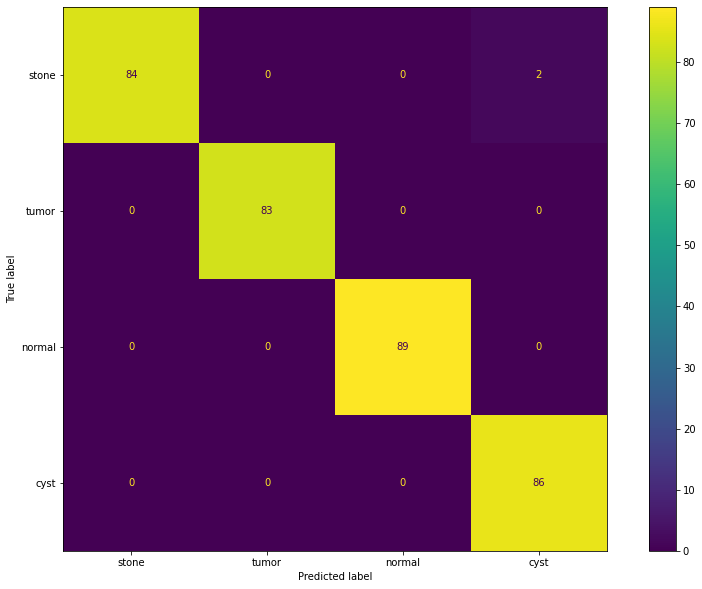

model SGD


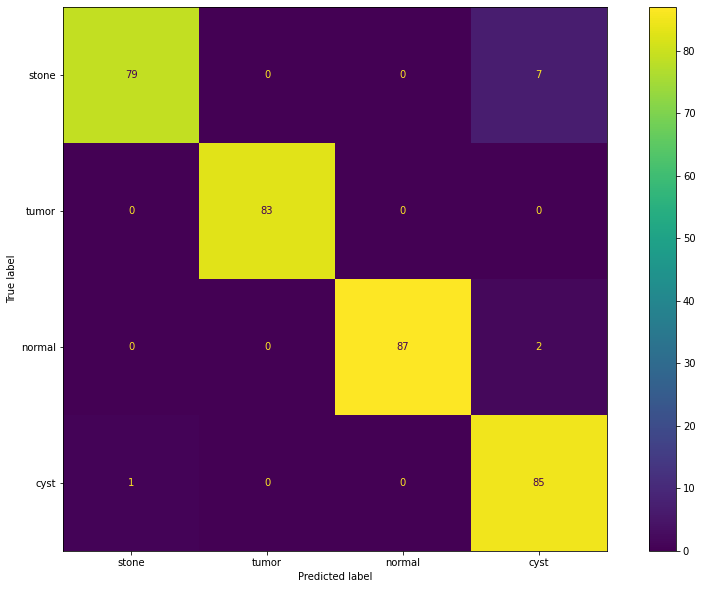

model Adamax


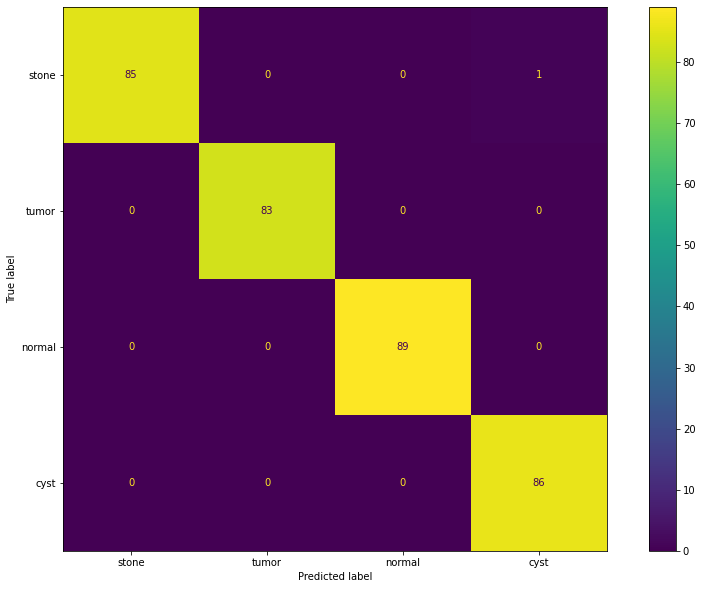

model MLP


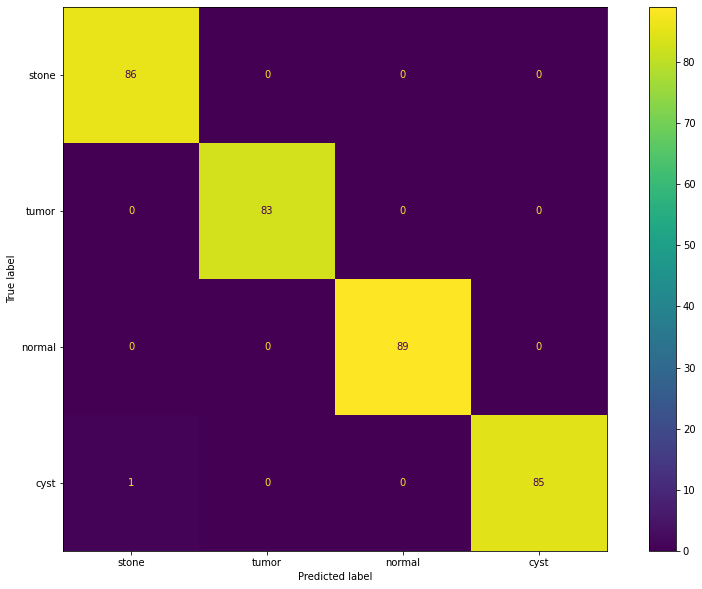

In [ ]:
predAdam = modelAdam.predict(X_test)
predSGD = modelSGD.predict(X_test)
predAdamax = modelAdamax.predict(X_test)
predMLP = modelMLP.predict(X_test)
cmAdam = confusion_matrix(y_test,np.argmax(predAdam, axis=-1))
cmSGD = confusion_matrix(y_test,np.argmax(predSGD, axis=-1))
cmAdamax = confusion_matrix(y_test,np.argmax(predAdamax, axis=-1))
cmMLP = confusion_matrix(y_test,np.argmax(predMLP, axis=-1))
print('model Adam')
disp = ConfusionMatrixDisplay(confusion_matrix=cmAdam, display_labels=class_to_int)
plt.rcParams['figure.figsize'] = [15, 10]
disp.plot()
plt.show()
print('model SGD')
disp2 = ConfusionMatrixDisplay(confusion_matrix=cmSGD, display_labels=class_to_int)
plt.rcParams['figure.figsize'] = [15, 10]
disp2.plot()
plt.show()
print('model Adamax')
disp3 = ConfusionMatrixDisplay(confusion_matrix=cmAdamax, display_labels=class_to_int)
plt.rcParams['figure.figsize'] = [15, 10]
disp3.plot()
plt.show()
print('model MLP')
disp4 = ConfusionMatrixDisplay(confusion_matrix=cmMLP, display_labels=class_to_int)
plt.rcParams['figure.figsize'] = [15, 10]
disp4.plot()
plt.show()

In [ ]:
j = 0
posAdam = []
for i in y_test:
  if i != np.argmax(predAdam[j]):
    posAdam.append(j)
  j+= 1
j = 0
posSGD = []
for i in y_test:
  if i != np.argmax(predSGD[j]):
    posSGD.append(j)
  j+= 1
j = 0
posAdamax = []
for i in y_test:
  if i != np.argmax(predAdamax[j]):
    posAdamax.append(j)
  j+= 1
j = 0
posMLP = []
for i in y_test:
  if i != np.argmax(predMLP[j]):
    posMLP.append(j)
  j+= 1

In [ ]:
str(list(df_dados_test.iterrows())[i][1]).split()

['image',
 '/content/trabalho/normal/Normal-',
 '(2858).jpg',
 'target',
 '2',
 'Name:',
 '3,',
 'dtype:',
 'object']

In [ ]:
imageStrAdam = []
qtde = 4
for i in posAdam[0:qtde*qtde]:
  print(f'ADAM: pos={i} y_test[{i}]={int_to_class[y_test[i]]} pred[{i}]={int_to_class[np.argmax(predAdam[i])]}')
  fileloc = str(list(df_dados_test.iterrows())[i][1]).split()[1]+' '+str(list(df_dados_test.iterrows())[i][1]).split()[2]
  aux = [fileloc, int_to_class[y_test[i]], int_to_class[np.argmax(predAdam[i])]]
  imageStrAdam.append(aux)
imageStrSGD = []
qtde = 4
for i in posSGD[0:qtde*qtde]:
  print(f'SGD: pos={i} y_test[{i}]={int_to_class[y_test[i]]} pred[{i}]={int_to_class[np.argmax(predSGD[i])]}')
  fileloc = str(list(df_dados_test.iterrows())[i][1]).split()[1]+' '+str(list(df_dados_test.iterrows())[i][1]).split()[2]
  aux = [fileloc, int_to_class[y_test[i]], int_to_class[np.argmax(predSGD[i])]]
  imageStrSGD.append(aux)
imageStrAdamax = []
for i in posAdamax[0:qtde*qtde]:
  print(f'Adamax: pos={i} y_test[{i}]={int_to_class[y_test[i]]} pred[{i}]={int_to_class[np.argmax(predAdamax[i])]}')
  fileloc = str(list(df_dados_test.iterrows())[i][1]).split()[1]+' '+str(list(df_dados_test.iterrows())[i][1]).split()[2]
  aux = [fileloc, int_to_class[y_test[i]], int_to_class[np.argmax(predAdamax[i])]]
  imageStrAdamax.append(aux)
imageStrMLP = []
for i in posMLP[0:qtde*qtde]:
  print(f'MLP: pos={i} y_test[{i}]={int_to_class[y_test[i]]} pred[{i}]={int_to_class[np.argmax(predMLP[i])]}')
  fileloc = str(list(df_dados_test.iterrows())[i][1]).split()[1]+' '+str(list(df_dados_test.iterrows())[i][1]).split()[2]
  aux = [fileloc, int_to_class[y_test[i]], int_to_class[np.argmax(predMLP[i])]]
  imageStrMLP.append(aux)

ADAM: pos=64 y_test[64]=stone pred[64]=cyst
ADAM: pos=96 y_test[96]=stone pred[96]=cyst
SGD: pos=78 y_test[78]=stone pred[78]=cyst
SGD: pos=129 y_test[129]=stone pred[129]=cyst
SGD: pos=134 y_test[134]=stone pred[134]=cyst
SGD: pos=136 y_test[136]=normal pred[136]=cyst
SGD: pos=195 y_test[195]=stone pred[195]=cyst
SGD: pos=223 y_test[223]=cyst pred[223]=stone
SGD: pos=226 y_test[226]=stone pred[226]=cyst
SGD: pos=243 y_test[243]=normal pred[243]=cyst
SGD: pos=299 y_test[299]=stone pred[299]=cyst
SGD: pos=331 y_test[331]=stone pred[331]=cyst
Adamax: pos=129 y_test[129]=stone pred[129]=cyst
MLP: pos=223 y_test[223]=cyst pred[223]=stone
/content/trabalho/stone/Stone- (918).jpg
/content/trabalho/stone/Stone- (860).jpg
/content/trabalho/stone/Stone- (128).jpg
/content/trabalho/normal/Normal- (1842).jpg
/content/trabalho/stone/Stone- (735).jpg
/content/trabalho/cyst/Cyst- (1040).jpg
/content/trabalho/stone/Stone- (129).jpg
/content/trabalho/normal/Normal- (1836).jpg
/content/trabalho/stone/S